In [1]:
import sys  
sys.path.insert(0, '../py')
from graviti import *

from numpy.linalg import norm
import numpy as np
import os
import os.path
from os import path
import sys
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import hdbscan
import pandas as pd
import umap
import networkx as nx
from scipy import sparse, linalg
import pickle
from sklearn.preprocessing import normalize, scale
from scipy.sparse import find
from numpy.linalg import norm
import timeit
import multiprocessing
from joblib import Parallel, delayed
from datetime import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [46]:
dirname = '../h5/id_52/' # the path to *features.npz files 
#dirname = '../data/id_52/' # the path to *features.npz files 
sample = '52' #sys.argv[2]  # the sample id
size = 500000 # number of nuclei, use negative value for full set
nn = 10 # set the number of nearest neighbor in the umap-graph. Will be used in CovD as well

features = ['area',
            'perimeter',
            'solidity',
            'eccentricity',
            'circularity',
            'mean_intensity',
            'std_intensity',
            #'cov_intensity',
           ]

In [3]:
counter = 0
for f in glob.glob(dirname+'/*features.npz'): # for every fov
    counter += 1
    if counter == 1:            # set up the data arrays
        data = np.load(f,allow_pickle=True)
        fov = data['fov']
        xy = data['centroids']
        morphology = data['morphology']
    else:                       # update the data arrays
        data = np.load(f,allow_pickle=True)
        fov = np.vstack((fov,data['fov']))
        xy = np.vstack((xy, data['centroids']))
        morphology = np.vstack((morphology, data['morphology']))

# Create dataframes with spatial and morphological measurements
df_fov = pd.DataFrame(data=fov, columns=['fov_row','fov_col']) # field of view dataframe
df_xy = pd.DataFrame(data=xy, columns=['cx','cy'])   # centroid dataframe
df_morphology = pd.DataFrame(data=morphology, columns=['area','perimeter','solidity','eccentricity','circularity','mean_intensity','std_intensity'])

# Concatenate spatial and morphological dataframes
df = pd.concat([df_fov,df_xy, df_morphology],axis=1)

In [47]:
# filter by percentiles in morphologies (hardcoded in function filtering) and introduce coeff. of var
if size == 0:
    fdf = filtering(df) # filter out extremes in morphology
else:
    fdf = filtering(df).sample(n=size) # filter out morphological outlyers and subsample nuclei

pos = fdf[fdf.columns[2:4]].to_numpy() # Get the positions of centroids 

# Building the UMAP graph
#filename = '../py/ID'+str(sample)+'.size'+str(size)+'.nn'+str(nn)+'.graph.npz' # the adj sparse matrix
print('Creating the graph')
A = space2graph(pos,nn)
#sparse.save_npz(filename, A)

Creating the graph


In [48]:
# Generation of the nn of the sampled nodes
from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors
X = df[df.columns[2:4]].to_numpy() # the full array of position
n_neighbors = df.shape[0]//size + 10
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree',n_jobs=-1).fit(X) 
distances, indices = nbrs.kneighbors(X)

In [49]:
# Parallel generation of the local covd
data = scale(df[features].to_numpy(), with_mean=False) #get the morphological data and rescale the data by std 

# Get numb of cores
num_cores = multiprocessing.cpu_count() # numb of cores
    
#filename = '../py/ID'+str(sample)+'.size'+str(size)+'.nn'+str(nn)+'.descriptor.pickle'    # the descriptor
print('Generating the descriptor')
processed_list = Parallel(n_jobs=num_cores)(delayed(covd_parallel_sparse)(node,data,indices) 
                                                            for node in tqdm(list(fdf.index))
                                                   )





  0%|          | 0/500000 [00:00<?, ?it/s]

Generating the descriptor






  0%|          | 4/500000 [00:00<7:50:01, 17.73it/s]



  0%|          | 8/500000 [00:06<66:21:36,  2.09it/s]



  0%|          | 12/500000 [00:06<47:59:24,  2.89it/s]



  0%|          | 36/500000 [00:06<33:46:45,  4.11it/s]



  0%|          | 72/500000 [00:06<23:46:04,  5.84it/s]



  0%|          | 280/500000 [00:06<16:39:11,  8.34it/s]



  0%|          | 792/500000 [00:06<11:39:25, 11.90it/s]



  0%|          | 1924/500000 [00:06<8:08:42, 16.99it/s]



  1%|          | 2778/500000 [00:06<5:41:48, 24.24it/s]



  1%|          | 4120/500000 [00:07<3:58:52, 34.60it/s]



  1%|          | 6168/500000 [00:07<2:46:41, 49.38it/s]



  2%|▏         | 8216/500000 [00:07<1:56:27, 70.38it/s]



  2%|▏         | 10264/500000 [00:07<1:21:24, 100.26it/s]



  2%|▏         | 12312/500000 [00:07<56:59, 142.60it/s]  



  3%|▎         | 14360/500000 [00:08<40:01, 202.20it/s]



  3%|▎         | 16408/500000 [00:08<28:09, 286.28it/s]



  4%|▎         | 18456/500000 [00:08<19:51, 404.22it/s]


 87%|████████▋ | 434200/500000 [00:53<00:07, 9328.10it/s]



 87%|████████▋ | 436248/500000 [00:54<00:06, 9389.71it/s]



 88%|████████▊ | 438296/500000 [00:54<00:06, 9455.12it/s]



 88%|████████▊ | 440344/500000 [00:54<00:06, 9651.45it/s]



 88%|████████▊ | 442392/500000 [00:54<00:05, 9936.83it/s]



 89%|████████▉ | 444440/500000 [00:54<00:05, 9802.18it/s]



 89%|████████▉ | 446488/500000 [00:55<00:05, 9839.26it/s]



 90%|████████▉ | 448536/500000 [00:55<00:05, 9756.61it/s]



 90%|█████████ | 450584/500000 [00:55<00:05, 9687.51it/s]



 91%|█████████ | 452632/500000 [00:55<00:04, 9920.37it/s]



 91%|█████████ | 454680/500000 [00:55<00:04, 9589.97it/s]



 91%|█████████▏| 456728/500000 [00:56<00:04, 9703.58it/s]



 92%|█████████▏| 458776/500000 [00:56<00:05, 7958.32it/s]



 92%|█████████▏| 460824/500000 [00:56<00:04, 8709.67it/s]



 93%|█████████▎| 462872/500000 [00:56<00:04, 9171.20it/s]



 93%|█████████▎| 464920/500000 [00:57<00:03, 8938.97it/s]



 93%|█████████▎| 466968/

In [50]:
# Construct the descriptor array
descriptor = np.zeros((len(processed_list),processed_list[0][1].shape[0]))
for r in range(len(processed_list)):
    descriptor[r,:] = processed_list[r][1] # covd descriptors of the connected nodes
#pickle.dump( descriptor, open( filename, "wb" ) )

In [51]:
# Get info about the graph
row_idx, col_idx, values = find(A) #A.nonzero() # nonzero entries
print('Generating the diversity index')
fdf['diversity'] = Parallel(n_jobs=num_cores)(delayed(covd_gradient_parallel)(node,
                                                                          descriptor,
                                                                          row_idx,col_idx,values) 
                               for node in tqdm(range(descriptor.shape[0])))





  0%|          | 0/500000 [00:00<?, ?it/s]

Generating the diversity index






  0%|          | 1/500000 [00:00<103:16:57,  1.34it/s]



  0%|          | 4/500000 [00:00<75:40:18,  1.84it/s] 



  0%|          | 8/500000 [00:06<113:49:33,  1.22it/s]



  0%|          | 12/500000 [00:07<81:47:28,  1.70it/s]



  0%|          | 16/500000 [00:07<58:19:18,  2.38it/s]



  0%|          | 28/500000 [00:07<41:17:40,  3.36it/s]



  0%|          | 40/500000 [00:07<29:18:26,  4.74it/s]



  0%|          | 72/500000 [00:07<20:39:56,  6.72it/s]



  0%|          | 120/500000 [00:07<14:36:24,  9.51it/s]



  0%|          | 152/500000 [00:07<10:24:41, 13.34it/s]



  0%|          | 184/500000 [00:07<7:25:19, 18.71it/s] 



  0%|          | 216/500000 [00:08<5:21:21, 25.92it/s]



  0%|          | 248/500000 [00:08<3:55:56, 35.30it/s]



  0%|          | 312/500000 [00:08<2:53:34, 47.98it/s]



  0%|          | 376/500000 [00:08<2:11:06, 63.51it/s]



  0%|          | 408/500000 [00:08<1:40:10, 83.11it/s]



  0%|          | 472/500000 [00:08<1:17:32, 107.38it/s]



  0%| 

  1%|▏         | 6968/500000 [00:30<28:05, 292.55it/s]



  1%|▏         | 7032/500000 [00:30<26:54, 305.43it/s]



  1%|▏         | 7096/500000 [00:30<26:39, 308.18it/s]



  1%|▏         | 7160/500000 [00:31<26:22, 311.34it/s]



  1%|▏         | 7224/500000 [00:31<26:19, 312.05it/s]



  1%|▏         | 7288/500000 [00:31<27:30, 298.54it/s]



  1%|▏         | 7352/500000 [00:31<26:29, 310.00it/s]



  1%|▏         | 7416/500000 [00:31<25:35, 320.76it/s]



  1%|▏         | 7480/500000 [00:32<25:38, 320.23it/s]



  2%|▏         | 7544/500000 [00:32<27:47, 295.33it/s]



  2%|▏         | 7608/500000 [00:32<27:27, 298.93it/s]



  2%|▏         | 7672/500000 [00:32<25:59, 315.76it/s]



  2%|▏         | 7736/500000 [00:33<25:52, 317.04it/s]



  2%|▏         | 7800/500000 [00:33<26:06, 314.18it/s]



  2%|▏         | 7864/500000 [00:33<25:39, 319.70it/s]



  2%|▏         | 7928/500000 [00:33<25:47, 317.91it/s]



  2%|▏         | 7992/500000 [00:33<25:17, 324.31it/s]



  2%|▏        

  4%|▍         | 21752/500000 [01:17<24:48, 321.39it/s]



  4%|▍         | 21816/500000 [01:18<25:10, 316.62it/s]



  4%|▍         | 21880/500000 [01:18<25:32, 312.03it/s]



  4%|▍         | 21944/500000 [01:18<26:41, 298.55it/s]



  4%|▍         | 22008/500000 [01:18<26:53, 296.22it/s]



  4%|▍         | 22072/500000 [01:19<25:32, 311.83it/s]



  4%|▍         | 22136/500000 [01:19<24:27, 325.74it/s]



  4%|▍         | 22200/500000 [01:19<24:52, 320.10it/s]



  4%|▍         | 22264/500000 [01:19<25:10, 316.28it/s]



  4%|▍         | 22328/500000 [01:19<24:11, 329.12it/s]



  4%|▍         | 22392/500000 [01:19<23:35, 337.35it/s]



  4%|▍         | 22456/500000 [01:20<24:47, 320.97it/s]



  5%|▍         | 22520/500000 [01:20<25:19, 314.28it/s]



  5%|▍         | 22584/500000 [01:20<25:41, 309.65it/s]



  5%|▍         | 22648/500000 [01:20<25:26, 312.70it/s]



  5%|▍         | 22712/500000 [01:21<24:57, 318.62it/s]



  5%|▍         | 22776/500000 [01:21<25:58, 306.21it/s]


  7%|▋         | 36472/500000 [02:05<25:07, 307.42it/s]



  7%|▋         | 36536/500000 [02:05<25:24, 304.08it/s]



  7%|▋         | 36600/500000 [02:05<25:58, 297.36it/s]



  7%|▋         | 36664/500000 [02:05<25:15, 305.64it/s]



  7%|▋         | 36728/500000 [02:06<25:10, 306.65it/s]



  7%|▋         | 36792/500000 [02:06<24:36, 313.81it/s]



  7%|▋         | 36856/500000 [02:06<24:02, 321.16it/s]



  7%|▋         | 36920/500000 [02:06<24:29, 315.16it/s]



  7%|▋         | 36984/500000 [02:06<23:55, 322.64it/s]



  7%|▋         | 37048/500000 [02:07<24:24, 316.03it/s]



  7%|▋         | 37112/500000 [02:07<23:44, 324.94it/s]



  7%|▋         | 37176/500000 [02:07<23:33, 327.41it/s]



  7%|▋         | 37240/500000 [02:07<23:25, 329.14it/s]



  7%|▋         | 37304/500000 [02:07<24:12, 318.55it/s]



  7%|▋         | 37368/500000 [02:08<25:30, 302.21it/s]



  7%|▋         | 37432/500000 [02:08<24:28, 314.94it/s]



  7%|▋         | 37496/500000 [02:08<24:37, 312.93it/s]


 10%|█         | 51192/500000 [02:52<24:10, 309.42it/s]



 10%|█         | 51256/500000 [02:52<25:03, 298.53it/s]



 10%|█         | 51320/500000 [02:53<25:06, 297.84it/s]



 10%|█         | 51384/500000 [02:53<24:26, 305.85it/s]



 10%|█         | 51448/500000 [02:53<24:40, 303.00it/s]



 10%|█         | 51512/500000 [02:53<24:03, 310.77it/s]



 10%|█         | 51576/500000 [02:53<24:37, 303.48it/s]



 10%|█         | 51640/500000 [02:54<25:12, 296.51it/s]



 10%|█         | 51704/500000 [02:54<25:06, 297.55it/s]



 10%|█         | 51768/500000 [02:54<23:26, 318.80it/s]



 10%|█         | 51832/500000 [02:54<23:49, 313.59it/s]



 10%|█         | 51896/500000 [02:54<22:24, 333.22it/s]



 10%|█         | 51960/500000 [02:55<21:34, 346.24it/s]



 10%|█         | 52024/500000 [02:55<21:48, 342.35it/s]



 10%|█         | 52088/500000 [02:55<23:40, 315.41it/s]



 10%|█         | 52152/500000 [02:55<24:15, 307.61it/s]



 10%|█         | 52216/500000 [02:55<23:16, 320.60it/s]


 13%|█▎        | 65912/500000 [03:41<22:35, 320.26it/s]



 13%|█▎        | 65976/500000 [03:41<25:17, 286.00it/s]



 13%|█▎        | 66040/500000 [03:41<24:37, 293.78it/s]



 13%|█▎        | 66104/500000 [03:41<23:03, 313.64it/s]



 13%|█▎        | 66168/500000 [03:42<22:59, 314.42it/s]



 13%|█▎        | 66232/500000 [03:42<23:23, 309.06it/s]



 13%|█▎        | 66296/500000 [03:42<23:23, 309.06it/s]



 13%|█▎        | 66360/500000 [03:42<23:55, 302.00it/s]



 13%|█▎        | 66424/500000 [03:42<24:09, 299.18it/s]



 13%|█▎        | 66488/500000 [03:43<23:59, 301.05it/s]



 13%|█▎        | 66552/500000 [03:43<25:03, 288.26it/s]



 13%|█▎        | 66616/500000 [03:43<23:27, 307.86it/s]



 13%|█▎        | 66680/500000 [03:43<25:09, 287.04it/s]



 13%|█▎        | 66744/500000 [03:44<24:30, 294.57it/s]



 13%|█▎        | 66808/500000 [03:44<25:22, 284.46it/s]



 13%|█▎        | 66872/500000 [03:44<24:23, 295.96it/s]



 13%|█▎        | 66936/500000 [03:44<24:14, 297.68it/s]


 16%|█▌        | 80632/500000 [04:28<23:04, 302.99it/s]



 16%|█▌        | 80696/500000 [04:28<21:38, 322.82it/s]



 16%|█▌        | 80760/500000 [04:28<20:24, 342.31it/s]



 16%|█▌        | 80824/500000 [04:29<21:45, 320.97it/s]



 16%|█▌        | 80888/500000 [04:29<21:43, 321.53it/s]



 16%|█▌        | 80952/500000 [04:29<24:17, 287.50it/s]



 16%|█▌        | 81016/500000 [04:29<23:07, 301.96it/s]



 16%|█▌        | 81080/500000 [04:29<22:04, 316.23it/s]



 16%|█▌        | 81144/500000 [04:30<21:06, 330.80it/s]



 16%|█▌        | 81208/500000 [04:30<21:17, 327.81it/s]



 16%|█▋        | 81272/500000 [04:30<22:05, 315.91it/s]



 16%|█▋        | 81336/500000 [04:30<22:32, 309.50it/s]



 16%|█▋        | 81400/500000 [04:30<22:34, 309.11it/s]



 16%|█▋        | 81464/500000 [04:31<21:33, 323.66it/s]



 16%|█▋        | 81528/500000 [04:31<20:58, 332.61it/s]



 16%|█▋        | 81592/500000 [04:31<20:45, 335.84it/s]



 16%|█▋        | 81656/500000 [04:31<21:46, 320.16it/s]


 19%|█▉        | 95352/500000 [05:15<20:45, 324.99it/s]



 19%|█▉        | 95416/500000 [05:15<22:29, 299.90it/s]



 19%|█▉        | 95480/500000 [05:16<23:17, 289.49it/s]



 19%|█▉        | 95544/500000 [05:16<23:07, 291.42it/s]



 19%|█▉        | 95608/500000 [05:16<22:14, 303.00it/s]



 19%|█▉        | 95672/500000 [05:16<23:22, 288.31it/s]



 19%|█▉        | 95736/500000 [05:16<22:04, 305.18it/s]



 19%|█▉        | 95800/500000 [05:17<21:38, 311.35it/s]



 19%|█▉        | 95864/500000 [05:17<21:23, 314.85it/s]



 19%|█▉        | 95928/500000 [05:17<21:58, 306.37it/s]



 19%|█▉        | 95992/500000 [05:17<22:39, 297.22it/s]



 19%|█▉        | 96056/500000 [05:17<21:58, 306.47it/s]



 19%|█▉        | 96120/500000 [05:18<20:40, 325.59it/s]



 19%|█▉        | 96184/500000 [05:18<20:16, 331.96it/s]



 19%|█▉        | 96248/500000 [05:18<19:21, 347.51it/s]



 19%|█▉        | 96312/500000 [05:18<20:44, 324.38it/s]



 19%|█▉        | 96376/500000 [05:18<19:42, 341.32it/s]


 22%|██▏       | 109880/500000 [06:02<20:15, 320.99it/s]



 22%|██▏       | 109944/500000 [06:02<20:30, 316.89it/s]



 22%|██▏       | 110008/500000 [06:02<20:30, 316.84it/s]



 22%|██▏       | 110072/500000 [06:03<21:00, 309.45it/s]



 22%|██▏       | 110136/500000 [06:03<20:10, 322.04it/s]



 22%|██▏       | 110200/500000 [06:03<20:05, 323.33it/s]



 22%|██▏       | 110264/500000 [06:03<20:41, 313.92it/s]



 22%|██▏       | 110328/500000 [06:03<20:45, 312.85it/s]



 22%|██▏       | 110392/500000 [06:04<21:13, 305.92it/s]



 22%|██▏       | 110456/500000 [06:04<20:49, 311.78it/s]



 22%|██▏       | 110520/500000 [06:04<21:30, 301.76it/s]



 22%|██▏       | 110584/500000 [06:04<20:46, 312.38it/s]



 22%|██▏       | 110648/500000 [06:04<20:14, 320.47it/s]



 22%|██▏       | 110712/500000 [06:05<20:19, 319.14it/s]



 22%|██▏       | 110776/500000 [06:05<20:59, 309.11it/s]



 22%|██▏       | 110840/500000 [06:05<19:53, 326.19it/s]



 22%|██▏       | 110904/500000 [06:05<20

 25%|██▍       | 124344/500000 [06:49<21:40, 288.94it/s]



 25%|██▍       | 124408/500000 [06:49<21:16, 294.32it/s]



 25%|██▍       | 124472/500000 [06:49<19:55, 314.02it/s]



 25%|██▍       | 124536/500000 [06:49<19:17, 324.46it/s]



 25%|██▍       | 124600/500000 [06:49<19:29, 321.11it/s]



 25%|██▍       | 124664/500000 [06:50<20:44, 301.64it/s]



 25%|██▍       | 124728/500000 [06:50<21:11, 295.13it/s]



 25%|██▍       | 124792/500000 [06:50<20:47, 300.77it/s]



 25%|██▍       | 124856/500000 [06:50<20:12, 309.52it/s]



 25%|██▍       | 124920/500000 [06:50<20:02, 311.97it/s]



 25%|██▍       | 124984/500000 [06:51<20:11, 309.50it/s]



 25%|██▌       | 125048/500000 [06:51<19:50, 314.86it/s]



 25%|██▌       | 125112/500000 [06:51<20:44, 301.16it/s]



 25%|██▌       | 125176/500000 [06:51<20:41, 302.00it/s]



 25%|██▌       | 125240/500000 [06:51<20:34, 303.57it/s]



 25%|██▌       | 125304/500000 [06:52<20:15, 308.29it/s]



 25%|██▌       | 125368/500000 [06:52<19

 28%|██▊       | 138808/500000 [07:35<20:22, 295.56it/s]



 28%|██▊       | 138872/500000 [07:35<20:15, 297.15it/s]



 28%|██▊       | 138936/500000 [07:35<20:08, 298.84it/s]



 28%|██▊       | 139000/500000 [07:35<19:23, 310.22it/s]



 28%|██▊       | 139064/500000 [07:35<19:39, 305.90it/s]



 28%|██▊       | 139128/500000 [07:36<19:18, 311.42it/s]



 28%|██▊       | 139192/500000 [07:36<19:21, 310.70it/s]



 28%|██▊       | 139256/500000 [07:36<18:30, 324.90it/s]



 28%|██▊       | 139320/500000 [07:36<18:01, 333.49it/s]



 28%|██▊       | 139384/500000 [07:36<18:29, 325.11it/s]



 28%|██▊       | 139448/500000 [07:37<18:31, 324.36it/s]



 28%|██▊       | 139512/500000 [07:37<18:10, 330.59it/s]



 28%|██▊       | 139576/500000 [07:37<18:49, 319.12it/s]



 28%|██▊       | 139640/500000 [07:37<19:08, 313.84it/s]



 28%|██▊       | 139704/500000 [07:37<19:07, 313.97it/s]



 28%|██▊       | 139768/500000 [07:38<20:01, 299.77it/s]



 28%|██▊       | 139832/500000 [07:38<19

 31%|███       | 153272/500000 [08:21<18:11, 317.64it/s]



 31%|███       | 153336/500000 [08:21<19:41, 293.43it/s]



 31%|███       | 153400/500000 [08:21<19:44, 292.58it/s]



 31%|███       | 153464/500000 [08:22<19:18, 299.16it/s]



 31%|███       | 153528/500000 [08:22<18:23, 314.07it/s]



 31%|███       | 153592/500000 [08:22<18:03, 319.57it/s]



 31%|███       | 153656/500000 [08:22<18:24, 313.66it/s]



 31%|███       | 153720/500000 [08:23<19:12, 300.49it/s]



 31%|███       | 153784/500000 [08:23<18:40, 309.09it/s]



 31%|███       | 153848/500000 [08:23<17:36, 327.60it/s]



 31%|███       | 153912/500000 [08:23<17:57, 321.30it/s]



 31%|███       | 153976/500000 [08:23<19:10, 300.77it/s]



 31%|███       | 154040/500000 [08:24<19:13, 299.96it/s]



 31%|███       | 154104/500000 [08:24<20:23, 282.75it/s]



 31%|███       | 154168/500000 [08:24<19:44, 291.88it/s]



 31%|███       | 154232/500000 [08:24<19:34, 294.33it/s]



 31%|███       | 154296/500000 [08:24<18

 34%|███▎      | 167736/500000 [09:08<19:27, 284.66it/s]



 34%|███▎      | 167800/500000 [09:08<18:26, 300.20it/s]



 34%|███▎      | 167864/500000 [09:08<17:16, 320.51it/s]



 34%|███▎      | 167928/500000 [09:08<16:46, 330.08it/s]



 34%|███▎      | 167992/500000 [09:08<17:53, 309.13it/s]



 34%|███▎      | 168056/500000 [09:09<16:55, 326.74it/s]



 34%|███▎      | 168120/500000 [09:09<16:55, 326.71it/s]



 34%|███▎      | 168184/500000 [09:09<16:49, 328.64it/s]



 34%|███▎      | 168248/500000 [09:09<16:58, 325.81it/s]



 34%|███▎      | 168312/500000 [09:09<16:50, 328.28it/s]



 34%|███▎      | 168376/500000 [09:10<16:59, 325.38it/s]



 34%|███▎      | 168440/500000 [09:10<17:34, 314.57it/s]



 34%|███▎      | 168504/500000 [09:10<18:03, 305.98it/s]



 34%|███▎      | 168568/500000 [09:10<17:01, 324.41it/s]



 34%|███▎      | 168632/500000 [09:10<17:47, 310.38it/s]



 34%|███▎      | 168696/500000 [09:11<17:02, 324.15it/s]



 34%|███▍      | 168760/500000 [09:11<17

 36%|███▋      | 182200/500000 [09:57<16:58, 312.07it/s]



 36%|███▋      | 182264/500000 [09:57<17:15, 306.94it/s]



 36%|███▋      | 182328/500000 [09:57<17:17, 306.25it/s]



 36%|███▋      | 182392/500000 [09:57<16:06, 328.62it/s]



 36%|███▋      | 182456/500000 [09:57<15:40, 337.46it/s]



 37%|███▋      | 182520/500000 [09:58<17:10, 308.05it/s]



 37%|███▋      | 182584/500000 [09:58<17:37, 300.15it/s]



 37%|███▋      | 182648/500000 [09:58<18:20, 288.47it/s]



 37%|███▋      | 182712/500000 [09:58<18:35, 284.55it/s]



 37%|███▋      | 182776/500000 [09:59<18:11, 290.51it/s]



 37%|███▋      | 182840/500000 [09:59<18:13, 289.93it/s]



 37%|███▋      | 182904/500000 [09:59<18:18, 288.55it/s]



 37%|███▋      | 182968/500000 [09:59<18:04, 292.25it/s]



 37%|███▋      | 183032/500000 [09:59<18:06, 291.79it/s]



 37%|███▋      | 183096/500000 [10:00<18:16, 288.99it/s]



 37%|███▋      | 183160/500000 [10:00<18:10, 290.58it/s]



 37%|███▋      | 183224/500000 [10:00<20

 39%|███▉      | 196664/500000 [10:46<16:37, 304.15it/s]



 39%|███▉      | 196728/500000 [10:46<16:28, 306.83it/s]



 39%|███▉      | 196792/500000 [10:47<15:30, 325.78it/s]



 39%|███▉      | 196856/500000 [10:47<16:07, 313.37it/s]



 39%|███▉      | 196920/500000 [10:47<16:53, 298.93it/s]



 39%|███▉      | 196984/500000 [10:47<16:10, 312.11it/s]



 39%|███▉      | 197048/500000 [10:47<15:44, 320.59it/s]



 39%|███▉      | 197112/500000 [10:48<15:47, 319.68it/s]



 39%|███▉      | 197176/500000 [10:48<15:40, 321.94it/s]



 39%|███▉      | 197240/500000 [10:48<16:09, 312.22it/s]



 39%|███▉      | 197304/500000 [10:48<15:29, 325.76it/s]



 39%|███▉      | 197368/500000 [10:48<16:26, 306.86it/s]



 39%|███▉      | 197432/500000 [10:49<17:03, 295.53it/s]



 39%|███▉      | 197496/500000 [10:49<17:02, 295.74it/s]



 40%|███▉      | 197560/500000 [10:49<16:05, 313.29it/s]



 40%|███▉      | 197624/500000 [10:49<15:45, 319.92it/s]



 40%|███▉      | 197688/500000 [10:49<15

 42%|████▏     | 211128/500000 [11:33<16:47, 286.75it/s]



 42%|████▏     | 211192/500000 [11:33<16:15, 296.01it/s]



 42%|████▏     | 211256/500000 [11:33<15:04, 319.08it/s]



 42%|████▏     | 211320/500000 [11:33<14:38, 328.70it/s]



 42%|████▏     | 211384/500000 [11:34<15:22, 313.03it/s]



 42%|████▏     | 211448/500000 [11:34<16:22, 293.59it/s]



 42%|████▏     | 211512/500000 [11:34<15:12, 316.15it/s]



 42%|████▏     | 211576/500000 [11:34<15:04, 318.92it/s]



 42%|████▏     | 211640/500000 [11:34<14:40, 327.35it/s]



 42%|████▏     | 211704/500000 [11:35<15:10, 316.67it/s]



 42%|████▏     | 211768/500000 [11:35<14:49, 324.19it/s]



 42%|████▏     | 211832/500000 [11:35<15:30, 309.81it/s]



 42%|████▏     | 211896/500000 [11:35<15:38, 307.02it/s]



 42%|████▏     | 211960/500000 [11:35<15:31, 309.38it/s]



 42%|████▏     | 212024/500000 [11:36<16:10, 296.79it/s]



 42%|████▏     | 212088/500000 [11:36<15:34, 308.21it/s]



 42%|████▏     | 212152/500000 [11:36<15

 45%|████▌     | 225592/500000 [12:19<14:43, 310.49it/s]



 45%|████▌     | 225656/500000 [12:20<14:54, 306.61it/s]



 45%|████▌     | 225720/500000 [12:20<15:08, 302.06it/s]



 45%|████▌     | 225784/500000 [12:20<15:04, 303.26it/s]



 45%|████▌     | 225848/500000 [12:20<14:41, 311.08it/s]



 45%|████▌     | 225912/500000 [12:20<13:56, 327.84it/s]



 45%|████▌     | 225976/500000 [12:21<13:46, 331.35it/s]



 45%|████▌     | 226040/500000 [12:21<14:01, 325.75it/s]



 45%|████▌     | 226104/500000 [12:21<15:01, 303.88it/s]



 45%|████▌     | 226168/500000 [12:21<15:25, 295.86it/s]



 45%|████▌     | 226232/500000 [12:22<15:38, 291.66it/s]



 45%|████▌     | 226296/500000 [12:22<14:55, 305.56it/s]



 45%|████▌     | 226360/500000 [12:22<14:19, 318.36it/s]



 45%|████▌     | 226424/500000 [12:22<14:10, 321.70it/s]



 45%|████▌     | 226488/500000 [12:22<14:43, 309.68it/s]



 45%|████▌     | 226552/500000 [12:23<15:37, 291.67it/s]



 45%|████▌     | 226616/500000 [12:23<15

 48%|████▊     | 240056/500000 [13:06<14:52, 291.13it/s]



 48%|████▊     | 240120/500000 [13:07<14:58, 289.25it/s]



 48%|████▊     | 240184/500000 [13:07<14:07, 306.41it/s]



 48%|████▊     | 240248/500000 [13:07<13:43, 315.55it/s]



 48%|████▊     | 240312/500000 [13:07<13:09, 328.90it/s]



 48%|████▊     | 240376/500000 [13:07<13:16, 325.99it/s]



 48%|████▊     | 240440/500000 [13:08<13:49, 312.77it/s]



 48%|████▊     | 240504/500000 [13:08<14:17, 302.58it/s]



 48%|████▊     | 240568/500000 [13:08<13:30, 320.20it/s]



 48%|████▊     | 240632/500000 [13:08<13:43, 314.82it/s]



 48%|████▊     | 240696/500000 [13:08<13:49, 312.61it/s]



 48%|████▊     | 240760/500000 [13:09<13:43, 314.80it/s]



 48%|████▊     | 240824/500000 [13:09<13:58, 309.02it/s]



 48%|████▊     | 240888/500000 [13:09<14:33, 296.57it/s]



 48%|████▊     | 240952/500000 [13:09<13:35, 317.67it/s]



 48%|████▊     | 241016/500000 [13:09<12:54, 334.35it/s]



 48%|████▊     | 241080/500000 [13:10<14

 51%|█████     | 254520/500000 [13:54<12:59, 315.02it/s]



 51%|█████     | 254584/500000 [13:54<13:19, 307.11it/s]



 51%|█████     | 254648/500000 [13:54<13:45, 297.14it/s]



 51%|█████     | 254712/500000 [13:55<13:42, 298.30it/s]



 51%|█████     | 254776/500000 [13:55<13:47, 296.42it/s]



 51%|█████     | 254840/500000 [13:55<13:28, 303.14it/s]



 51%|█████     | 254904/500000 [13:55<12:43, 320.96it/s]



 51%|█████     | 254968/500000 [13:55<12:28, 327.23it/s]



 51%|█████     | 255032/500000 [13:56<13:03, 312.81it/s]



 51%|█████     | 255096/500000 [13:56<12:18, 331.83it/s]



 51%|█████     | 255160/500000 [13:56<12:43, 320.84it/s]



 51%|█████     | 255224/500000 [13:56<12:42, 320.92it/s]



 51%|█████     | 255288/500000 [13:56<13:10, 309.50it/s]



 51%|█████     | 255352/500000 [13:57<13:16, 307.12it/s]



 51%|█████     | 255416/500000 [13:57<13:38, 298.69it/s]



 51%|█████     | 255480/500000 [13:57<12:59, 313.79it/s]



 51%|█████     | 255544/500000 [13:57<12

 54%|█████▍    | 268984/500000 [14:41<11:35, 332.09it/s]



 54%|█████▍    | 269048/500000 [14:42<13:03, 294.95it/s]



 54%|█████▍    | 269112/500000 [14:42<15:17, 251.53it/s]



 54%|█████▍    | 269176/500000 [14:42<15:37, 246.24it/s]



 54%|█████▍    | 269240/500000 [14:43<14:45, 260.58it/s]



 54%|█████▍    | 269304/500000 [14:43<13:34, 283.27it/s]



 54%|█████▍    | 269368/500000 [14:43<13:08, 292.52it/s]



 54%|█████▍    | 269432/500000 [14:43<12:27, 308.27it/s]



 54%|█████▍    | 269496/500000 [14:43<12:11, 315.24it/s]



 54%|█████▍    | 269560/500000 [14:44<12:08, 316.29it/s]



 54%|█████▍    | 269624/500000 [14:44<11:55, 321.83it/s]



 54%|█████▍    | 269688/500000 [14:44<11:44, 326.73it/s]



 54%|█████▍    | 269752/500000 [14:44<12:11, 314.68it/s]



 54%|█████▍    | 269816/500000 [14:44<13:07, 292.44it/s]



 54%|█████▍    | 269880/500000 [14:45<12:28, 307.42it/s]



 54%|█████▍    | 269944/500000 [14:45<12:29, 307.15it/s]



 54%|█████▍    | 270008/500000 [14:45<12

 57%|█████▋    | 283448/500000 [15:28<11:42, 308.25it/s]



 57%|█████▋    | 283512/500000 [15:29<12:03, 299.24it/s]



 57%|█████▋    | 283576/500000 [15:29<11:12, 321.76it/s]



 57%|█████▋    | 283640/500000 [15:29<11:13, 321.20it/s]



 57%|█████▋    | 283704/500000 [15:29<11:30, 313.31it/s]



 57%|█████▋    | 283768/500000 [15:29<11:18, 318.57it/s]



 57%|█████▋    | 283832/500000 [15:30<10:51, 331.87it/s]



 57%|█████▋    | 283896/500000 [15:30<11:03, 325.66it/s]



 57%|█████▋    | 283960/500000 [15:30<11:27, 314.32it/s]



 57%|█████▋    | 284024/500000 [15:30<11:11, 321.68it/s]



 57%|█████▋    | 284088/500000 [15:30<11:22, 316.46it/s]



 57%|█████▋    | 284152/500000 [15:31<11:14, 320.23it/s]



 57%|█████▋    | 284216/500000 [15:31<10:53, 330.37it/s]



 57%|█████▋    | 284280/500000 [15:31<10:51, 331.31it/s]



 57%|█████▋    | 284344/500000 [15:31<11:05, 323.83it/s]



 57%|█████▋    | 284408/500000 [15:31<11:15, 319.02it/s]



 57%|█████▋    | 284472/500000 [15:31<10

 60%|█████▉    | 297912/500000 [16:13<10:30, 320.63it/s]



 60%|█████▉    | 297976/500000 [16:14<10:17, 327.14it/s]



 60%|█████▉    | 298040/500000 [16:14<10:43, 313.69it/s]



 60%|█████▉    | 298104/500000 [16:14<10:39, 315.76it/s]



 60%|█████▉    | 298168/500000 [16:14<10:29, 320.73it/s]



 60%|█████▉    | 298232/500000 [16:14<10:29, 320.56it/s]



 60%|█████▉    | 298296/500000 [16:15<11:11, 300.53it/s]



 60%|█████▉    | 298360/500000 [16:15<10:32, 318.89it/s]



 60%|█████▉    | 298424/500000 [16:15<09:53, 339.57it/s]



 60%|█████▉    | 298488/500000 [16:15<09:30, 353.07it/s]



 60%|█████▉    | 298552/500000 [16:15<09:16, 362.24it/s]



 60%|█████▉    | 298616/500000 [16:15<09:36, 349.52it/s]



 60%|█████▉    | 298680/500000 [16:16<10:21, 323.84it/s]



 60%|█████▉    | 298744/500000 [16:16<10:48, 310.52it/s]



 60%|█████▉    | 298808/500000 [16:16<11:02, 303.49it/s]



 60%|█████▉    | 298872/500000 [16:16<10:55, 306.69it/s]



 60%|█████▉    | 298936/500000 [16:17<10

 62%|██████▏   | 312376/500000 [16:58<10:09, 307.70it/s]



 62%|██████▏   | 312440/500000 [16:58<09:56, 314.65it/s]



 63%|██████▎   | 312504/500000 [16:59<09:46, 319.95it/s]



 63%|██████▎   | 312568/500000 [16:59<09:17, 336.14it/s]



 63%|██████▎   | 312632/500000 [16:59<09:16, 336.63it/s]



 63%|██████▎   | 312696/500000 [16:59<09:30, 328.16it/s]



 63%|██████▎   | 312760/500000 [16:59<10:03, 310.50it/s]



 63%|██████▎   | 312824/500000 [17:00<09:56, 314.04it/s]



 63%|██████▎   | 312888/500000 [17:00<10:21, 300.83it/s]



 63%|██████▎   | 312952/500000 [17:00<10:00, 311.39it/s]



 63%|██████▎   | 313016/500000 [17:00<10:01, 310.96it/s]



 63%|██████▎   | 313080/500000 [17:00<09:44, 319.79it/s]



 63%|██████▎   | 313144/500000 [17:01<09:21, 332.84it/s]



 63%|██████▎   | 313208/500000 [17:01<09:25, 330.47it/s]



 63%|██████▎   | 313272/500000 [17:01<09:54, 314.17it/s]



 63%|██████▎   | 313336/500000 [17:01<09:57, 312.23it/s]



 63%|██████▎   | 313400/500000 [17:01<09

 65%|██████▌   | 326840/500000 [17:44<09:03, 318.51it/s]



 65%|██████▌   | 326904/500000 [17:44<09:05, 317.10it/s]



 65%|██████▌   | 326968/500000 [17:44<09:26, 305.19it/s]



 65%|██████▌   | 327032/500000 [17:44<09:26, 305.41it/s]



 65%|██████▌   | 327096/500000 [17:44<08:57, 321.43it/s]



 65%|██████▌   | 327160/500000 [17:45<08:20, 345.26it/s]



 65%|██████▌   | 327224/500000 [17:45<08:33, 336.38it/s]



 65%|██████▌   | 327288/500000 [17:45<09:02, 318.62it/s]



 65%|██████▌   | 327352/500000 [17:45<08:55, 322.39it/s]



 65%|██████▌   | 327416/500000 [17:45<08:48, 326.32it/s]



 65%|██████▌   | 327480/500000 [17:46<08:58, 320.31it/s]



 66%|██████▌   | 327544/500000 [17:46<08:54, 322.70it/s]



 66%|██████▌   | 327608/500000 [17:46<08:43, 329.58it/s]



 66%|██████▌   | 327672/500000 [17:46<08:41, 330.49it/s]



 66%|██████▌   | 327736/500000 [17:46<08:56, 320.93it/s]



 66%|██████▌   | 327800/500000 [17:47<09:13, 310.92it/s]



 66%|██████▌   | 327864/500000 [17:47<09

 68%|██████▊   | 341304/500000 [18:29<07:53, 335.21it/s]



 68%|██████▊   | 341368/500000 [18:29<09:05, 291.03it/s]



 68%|██████▊   | 341432/500000 [18:30<09:14, 286.15it/s]



 68%|██████▊   | 341496/500000 [18:30<08:52, 297.39it/s]



 68%|██████▊   | 341560/500000 [18:30<08:33, 308.64it/s]



 68%|██████▊   | 341624/500000 [18:30<08:27, 312.19it/s]



 68%|██████▊   | 341688/500000 [18:31<08:32, 309.01it/s]



 68%|██████▊   | 341752/500000 [18:31<08:11, 321.68it/s]



 68%|██████▊   | 341816/500000 [18:31<07:57, 331.14it/s]



 68%|██████▊   | 341880/500000 [18:31<07:47, 338.27it/s]



 68%|██████▊   | 341944/500000 [18:31<07:56, 331.36it/s]



 68%|██████▊   | 342008/500000 [18:31<08:03, 326.88it/s]



 68%|██████▊   | 342072/500000 [18:32<07:48, 337.02it/s]



 68%|██████▊   | 342136/500000 [18:32<08:19, 315.99it/s]



 68%|██████▊   | 342200/500000 [18:32<08:20, 315.34it/s]



 68%|██████▊   | 342264/500000 [18:32<08:26, 311.23it/s]



 68%|██████▊   | 342328/500000 [18:32<08

 71%|███████   | 355768/500000 [19:15<07:26, 322.79it/s]



 71%|███████   | 355832/500000 [19:15<07:17, 329.27it/s]



 71%|███████   | 355896/500000 [19:16<07:07, 337.05it/s]



 71%|███████   | 355960/500000 [19:16<07:44, 310.02it/s]



 71%|███████   | 356024/500000 [19:16<07:52, 304.77it/s]



 71%|███████   | 356088/500000 [19:16<07:21, 326.20it/s]



 71%|███████   | 356152/500000 [19:16<07:12, 332.40it/s]



 71%|███████   | 356216/500000 [19:17<06:58, 343.28it/s]



 71%|███████▏  | 356280/500000 [19:17<07:24, 323.00it/s]



 71%|███████▏  | 356344/500000 [19:17<07:25, 322.56it/s]



 71%|███████▏  | 356408/500000 [19:17<07:17, 328.53it/s]



 71%|███████▏  | 356472/500000 [19:17<07:07, 335.74it/s]



 71%|███████▏  | 356536/500000 [19:18<07:10, 332.91it/s]



 71%|███████▏  | 356600/500000 [19:18<07:13, 330.93it/s]



 71%|███████▏  | 356664/500000 [19:18<07:33, 315.97it/s]



 71%|███████▏  | 356728/500000 [19:18<07:45, 308.02it/s]



 71%|███████▏  | 356792/500000 [19:18<07

 74%|███████▍  | 370232/500000 [20:00<06:40, 323.71it/s]



 74%|███████▍  | 370296/500000 [20:00<06:31, 330.98it/s]



 74%|███████▍  | 370360/500000 [20:00<06:33, 329.73it/s]



 74%|███████▍  | 370424/500000 [20:01<06:29, 332.60it/s]



 74%|███████▍  | 370488/500000 [20:01<06:30, 331.64it/s]



 74%|███████▍  | 370552/500000 [20:01<06:42, 321.23it/s]



 74%|███████▍  | 370616/500000 [20:01<06:38, 324.53it/s]



 74%|███████▍  | 370680/500000 [20:01<06:44, 319.41it/s]



 74%|███████▍  | 370744/500000 [20:02<06:50, 315.24it/s]



 74%|███████▍  | 370808/500000 [20:02<06:44, 319.44it/s]



 74%|███████▍  | 370872/500000 [20:02<06:24, 335.71it/s]



 74%|███████▍  | 370936/500000 [20:02<06:20, 339.21it/s]



 74%|███████▍  | 371000/500000 [20:02<06:27, 333.22it/s]



 74%|███████▍  | 371064/500000 [20:03<06:43, 319.20it/s]



 74%|███████▍  | 371128/500000 [20:03<07:00, 306.68it/s]



 74%|███████▍  | 371192/500000 [20:03<06:47, 315.85it/s]



 74%|███████▍  | 371256/500000 [20:03<06

 77%|███████▋  | 384696/500000 [20:46<06:13, 308.96it/s]



 77%|███████▋  | 384760/500000 [20:46<06:13, 308.55it/s]



 77%|███████▋  | 384824/500000 [20:46<06:17, 304.76it/s]



 77%|███████▋  | 384888/500000 [20:46<05:55, 324.24it/s]



 77%|███████▋  | 384952/500000 [20:46<06:02, 317.18it/s]



 77%|███████▋  | 385016/500000 [20:47<06:18, 303.89it/s]



 77%|███████▋  | 385080/500000 [20:47<06:10, 309.85it/s]



 77%|███████▋  | 385144/500000 [20:47<05:56, 322.44it/s]



 77%|███████▋  | 385208/500000 [20:47<05:53, 324.96it/s]



 77%|███████▋  | 385272/500000 [20:47<05:49, 328.09it/s]



 77%|███████▋  | 385336/500000 [20:48<05:42, 334.56it/s]



 77%|███████▋  | 385400/500000 [20:48<05:47, 329.79it/s]



 77%|███████▋  | 385464/500000 [20:48<06:25, 297.10it/s]



 77%|███████▋  | 385528/500000 [20:48<06:06, 312.65it/s]



 77%|███████▋  | 385592/500000 [20:48<05:48, 328.38it/s]



 77%|███████▋  | 385656/500000 [20:49<05:34, 342.30it/s]



 77%|███████▋  | 385720/500000 [20:49<05

 80%|███████▉  | 399160/500000 [21:31<05:02, 333.12it/s]



 80%|███████▉  | 399224/500000 [21:31<05:10, 325.00it/s]



 80%|███████▉  | 399288/500000 [21:31<05:11, 323.56it/s]



 80%|███████▉  | 399352/500000 [21:31<05:10, 324.49it/s]



 80%|███████▉  | 399416/500000 [21:31<05:26, 308.17it/s]



 80%|███████▉  | 399480/500000 [21:32<05:13, 321.00it/s]



 80%|███████▉  | 399544/500000 [21:32<05:18, 315.36it/s]



 80%|███████▉  | 399608/500000 [21:32<05:34, 300.38it/s]



 80%|███████▉  | 399672/500000 [21:32<05:20, 312.81it/s]



 80%|███████▉  | 399736/500000 [21:32<05:12, 321.02it/s]



 80%|███████▉  | 399800/500000 [21:33<05:03, 330.66it/s]



 80%|███████▉  | 399864/500000 [21:33<05:20, 311.97it/s]



 80%|███████▉  | 399928/500000 [21:33<05:42, 291.89it/s]



 80%|███████▉  | 399992/500000 [21:33<05:33, 299.93it/s]



 80%|████████  | 400056/500000 [21:34<05:21, 311.02it/s]



 80%|████████  | 400120/500000 [21:34<05:14, 317.19it/s]



 80%|████████  | 400184/500000 [21:34<05

 83%|████████▎ | 413624/500000 [22:16<04:14, 339.39it/s]



 83%|████████▎ | 413688/500000 [22:16<04:15, 337.59it/s]



 83%|████████▎ | 413752/500000 [22:16<04:32, 316.36it/s]



 83%|████████▎ | 413816/500000 [22:16<04:28, 321.26it/s]



 83%|████████▎ | 413880/500000 [22:17<04:18, 332.63it/s]



 83%|████████▎ | 413944/500000 [22:17<04:17, 334.04it/s]



 83%|████████▎ | 414008/500000 [22:17<04:26, 322.56it/s]



 83%|████████▎ | 414072/500000 [22:17<04:30, 318.14it/s]



 83%|████████▎ | 414136/500000 [22:17<04:26, 322.25it/s]



 83%|████████▎ | 414200/500000 [22:18<04:29, 318.11it/s]



 83%|████████▎ | 414264/500000 [22:18<04:21, 328.48it/s]



 83%|████████▎ | 414328/500000 [22:18<04:32, 314.37it/s]



 83%|████████▎ | 414392/500000 [22:18<04:48, 296.67it/s]



 83%|████████▎ | 414456/500000 [22:18<04:45, 299.75it/s]



 83%|████████▎ | 414520/500000 [22:19<04:29, 316.60it/s]



 83%|████████▎ | 414584/500000 [22:19<04:14, 335.55it/s]



 83%|████████▎ | 414648/500000 [22:19<04

 86%|████████▌ | 428088/500000 [23:01<03:34, 335.74it/s]



 86%|████████▌ | 428152/500000 [23:01<03:53, 307.26it/s]



 86%|████████▌ | 428216/500000 [23:02<03:40, 325.13it/s]



 86%|████████▌ | 428280/500000 [23:02<03:51, 310.32it/s]



 86%|████████▌ | 428344/500000 [23:02<03:48, 313.04it/s]



 86%|████████▌ | 428408/500000 [23:02<03:48, 313.48it/s]



 86%|████████▌ | 428472/500000 [23:03<03:57, 301.16it/s]



 86%|████████▌ | 428536/500000 [23:03<03:42, 321.28it/s]



 86%|████████▌ | 428600/500000 [23:03<03:46, 315.85it/s]



 86%|████████▌ | 428664/500000 [23:03<03:48, 312.75it/s]



 86%|████████▌ | 428728/500000 [23:03<03:46, 314.93it/s]



 86%|████████▌ | 428792/500000 [23:03<03:33, 334.24it/s]



 86%|████████▌ | 428856/500000 [23:04<03:27, 342.57it/s]



 86%|████████▌ | 428920/500000 [23:04<03:33, 332.91it/s]



 86%|████████▌ | 428984/500000 [23:04<03:33, 332.43it/s]



 86%|████████▌ | 429048/500000 [23:04<03:43, 317.82it/s]



 86%|████████▌ | 429112/500000 [23:04<03

 89%|████████▊ | 442552/500000 [23:46<02:53, 331.55it/s]



 89%|████████▊ | 442616/500000 [23:47<02:59, 320.13it/s]



 89%|████████▊ | 442680/500000 [23:47<02:59, 320.03it/s]



 89%|████████▊ | 442744/500000 [23:47<02:55, 325.89it/s]



 89%|████████▊ | 442808/500000 [23:47<03:03, 310.92it/s]



 89%|████████▊ | 442872/500000 [23:47<02:55, 325.06it/s]



 89%|████████▊ | 442936/500000 [23:48<02:47, 340.03it/s]



 89%|████████▊ | 443000/500000 [23:48<02:42, 350.26it/s]



 89%|████████▊ | 443064/500000 [23:48<02:54, 326.85it/s]



 89%|████████▊ | 443128/500000 [23:48<03:13, 294.42it/s]



 89%|████████▊ | 443192/500000 [23:48<03:03, 310.41it/s]



 89%|████████▊ | 443256/500000 [23:49<02:55, 322.71it/s]



 89%|████████▊ | 443320/500000 [23:49<02:50, 331.52it/s]



 89%|████████▊ | 443384/500000 [23:49<02:59, 315.89it/s]



 89%|████████▊ | 443448/500000 [23:49<02:50, 331.05it/s]



 89%|████████▊ | 443512/500000 [23:49<02:57, 317.36it/s]



 89%|████████▊ | 443576/500000 [23:50<02

 91%|█████████▏| 457016/500000 [24:33<02:12, 324.31it/s]



 91%|█████████▏| 457080/500000 [24:33<02:12, 323.02it/s]



 91%|█████████▏| 457144/500000 [24:34<02:18, 308.45it/s]



 91%|█████████▏| 457208/500000 [24:34<02:22, 299.46it/s]



 91%|█████████▏| 457272/500000 [24:34<02:25, 293.90it/s]



 91%|█████████▏| 457336/500000 [24:34<02:20, 302.76it/s]



 91%|█████████▏| 457400/500000 [24:35<02:20, 304.15it/s]



 91%|█████████▏| 457464/500000 [24:35<02:28, 287.00it/s]



 92%|█████████▏| 457528/500000 [24:35<02:38, 267.78it/s]



 92%|█████████▏| 457592/500000 [24:35<03:06, 227.64it/s]



 92%|█████████▏| 457656/500000 [24:36<02:53, 243.44it/s]



 92%|█████████▏| 457720/500000 [24:36<03:01, 232.71it/s]



 92%|█████████▏| 457784/500000 [24:36<03:07, 225.25it/s]



 92%|█████████▏| 457848/500000 [24:37<03:10, 221.85it/s]



 92%|█████████▏| 457912/500000 [24:37<03:03, 229.56it/s]



 92%|█████████▏| 457976/500000 [24:37<02:49, 247.92it/s]



 92%|█████████▏| 458040/500000 [24:37<02

 94%|█████████▍| 471480/500000 [25:25<01:38, 288.19it/s]



 94%|█████████▍| 471544/500000 [25:26<01:37, 291.56it/s]



 94%|█████████▍| 471608/500000 [25:26<01:33, 302.97it/s]



 94%|█████████▍| 471672/500000 [25:26<01:36, 294.30it/s]



 94%|█████████▍| 471736/500000 [25:26<01:35, 296.52it/s]



 94%|█████████▍| 471800/500000 [25:26<01:34, 299.81it/s]



 94%|█████████▍| 471864/500000 [25:27<01:31, 309.15it/s]



 94%|█████████▍| 471928/500000 [25:27<01:29, 314.11it/s]



 94%|█████████▍| 471992/500000 [25:27<01:30, 308.40it/s]



 94%|█████████▍| 472056/500000 [25:27<01:31, 304.83it/s]



 94%|█████████▍| 472120/500000 [25:27<01:30, 307.85it/s]



 94%|█████████▍| 472184/500000 [25:28<01:25, 325.26it/s]



 94%|█████████▍| 472248/500000 [25:28<01:32, 299.13it/s]



 94%|█████████▍| 472312/500000 [25:28<01:28, 314.04it/s]



 94%|█████████▍| 472376/500000 [25:28<01:27, 314.21it/s]



 94%|█████████▍| 472440/500000 [25:28<01:27, 313.69it/s]



 95%|█████████▍| 472504/500000 [25:29<01

 97%|█████████▋| 485944/500000 [26:12<00:44, 318.51it/s]



 97%|█████████▋| 486008/500000 [26:13<00:47, 296.14it/s]



 97%|█████████▋| 486072/500000 [26:13<00:43, 317.29it/s]



 97%|█████████▋| 486136/500000 [26:13<00:43, 321.21it/s]



 97%|█████████▋| 486200/500000 [26:13<00:46, 296.58it/s]



 97%|█████████▋| 486264/500000 [26:13<00:46, 298.07it/s]



 97%|█████████▋| 486328/500000 [26:14<00:44, 306.12it/s]



 97%|█████████▋| 486392/500000 [26:14<00:42, 319.61it/s]



 97%|█████████▋| 486456/500000 [26:14<00:40, 337.45it/s]



 97%|█████████▋| 486520/500000 [26:14<00:38, 346.30it/s]



 97%|█████████▋| 486584/500000 [26:14<00:45, 296.32it/s]



 97%|█████████▋| 486648/500000 [26:15<00:43, 306.03it/s]



 97%|█████████▋| 486712/500000 [26:15<00:40, 325.19it/s]



 97%|█████████▋| 486776/500000 [26:15<00:40, 325.61it/s]



 97%|█████████▋| 486840/500000 [26:15<00:40, 322.99it/s]



 97%|█████████▋| 486904/500000 [26:15<00:42, 306.34it/s]



 97%|█████████▋| 486968/500000 [26:16<00

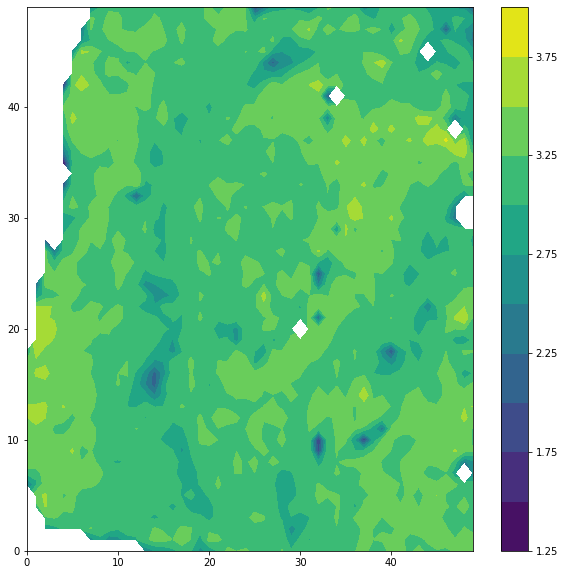

In [52]:
N = 50 # number of linear bins for the contour visualization

# Contour visualization
fdf['x_bin'] = pd.cut(fdf['cx'], N, labels=False) # define the x bin label
fdf['y_bin'] = pd.cut(fdf['cy'], N, labels=False) # define the y bin label

# define the pivot tabel for the contour plot
table = pd.pivot_table(fdf, 
                       values='diversity', 
                       index=['x_bin'],
                       columns=['y_bin'],
                       aggfunc=np.sum, # take the mean of the entries in the bin
                       fill_value=None)

X=table.columns.values
Y=table.index.values
Z=np.log10(table.values)
Xi,Yi = np.meshgrid(X, Y)

fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contourf(Yi, Xi, Z, 
                 alpha=1.0, 
                 levels=10,
                 cmap=plt.cm.viridis);
cbar = fig.colorbar(cs)
plt.savefig('test_sum.png')

In [ ]:
 plotlyContourPlot(fdf,filename)

In [ ]:
fdf['field'].plot.hist(bins=N)
plt.show()

In [ ]:
count_nuclei = fdf.groupby(['x_bin', 'y_bin']).size().to_numpy()

variability = fdf.groupby(['x_bin', 'y_bin'])['field'].sum().to_numpy()

test_df = pd.DataFrame(list(zip(count_nuclei, variability)),
                  columns=['count','variability'])

In [ ]:
print(test_df.corr(method='pearson'))
test_df.plot.scatter(x='count',y='variability')

In [ ]:
fdf.groupby(['x_bin', 'y_bin']).size().plot.hist(bins=N//10)

In [ ]:
fdf.groupby(['x_bin', 'y_bin'])['field'].mean().plot.hist(bins=N//10)

In [ ]:
import plotly.express as px
fig = px.scatter(fdf, 
                 x="x_bin", 
                 y="y_bin",
                 color="field",
                 #size=1,
                 opacity=0.5,
                 color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(template='simple_white',
                 height=800, width=800)

fig.show()

In [ ]:
# Build figure
fig = go.Figure()

# Add scatter trace with medium sized markers
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=fdf['x_bin'],
        y=fdf['y_bin'],
        marker=dict(
            color=fdf['field'],
            size=fdf['field'],
            opacity=0.5,
        ),
        showlegend=False
    )
)
fig.update_layout(template='simple_white',
                 height=500, width=500)
fig.show()